# Question 6 Study

Getting some funny results from question 6 and do not understand why.

**Answer**: Turns out the histogram just doesn't have the right limits! It is too short, so you miss the second spike, so it looks very different by eye!

## Last Plan Run (where b-tag looks right)

In [1]:
def web_load_data_from_sx():
    # Imports for ServiceX and func_adl
    from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
    from func_adl_servicex_xaodr25.xAOD.jet_v1 import Jet_v1
    from servicex_analysis_utils import to_awk
    from servicex import deliver, ServiceXSpec, Sample, dataset

    # We need these for the local accessor and tool helpers
    import ast
    from dataclasses import dataclass
    from typing import Tuple, TypeVar, Callable, Iterable, List, Optional
    from func_adl import ObjectStream, func_adl_callable

    T = TypeVar("T")

    # ---- xAOD Tool Access helpers (must be present) ----
    @dataclass
    class ToolInfo:
        name: str

    def make_a_tool(
        query: ObjectStream[T],
        tool_name: str,
        tool_type: str,
        include_files: Optional[List[str]],
        init_lines: List[str] = [],
    ) -> Tuple[ObjectStream[T], ToolInfo]:
        query_base = query.MetaData(
            {
                "metadata_type": "inject_code",
                "name": tool_name,
                "header_includes": include_files or [],
                "private_members": [f"{tool_type} *{tool_name};"],
                "instance_initialization": [
                    f'{tool_name}(new {tool_type} ("{tool_name}"))'
                ],
                "initialize_lines": [l.format(tool_name=tool_name) for l in init_lines],
                "link_libraries": ["xAODBTaggingEfficiencyLib"],
            }
        )
        return query_base, ToolInfo(name=tool_name)

    def make_tool_accessor(
        t_info: ToolInfo,
        function_name: str,
        source_code: List[str],
        arguments: Iterable[Tuple[str, type]],
        return_type_cpp: str,
        return_type_python: str,
    ):
        def tool_callback(
            s: ObjectStream[T], a: ast.Call
        ) -> Tuple[ObjectStream[T], ast.Call]:
            new_s = s.MetaData(
                {
                    "metadata_type": "add_cpp_function",
                    "name": function_name,
                    "code": [
                        "double result;",
                        *[l.format(tool_name=t_info.name) for l in source_code],
                    ],
                    "result": "result",
                    "include_files": [],
                    "arguments": [arg_name for arg_name, _ in arguments],
                    "return_type": return_type_cpp,
                }
            )
            return new_s, a

        def tool_call(**arg_dict): ...

        tool_call.__name__ = function_name
        tool_call.__annotations__["return"] = eval(return_type_python)

        return func_adl_callable(tool_callback)(tool_call)

    # ---- end tool helpers ----

    # Base query on PHYSLITE
    physlite = FuncADLQueryPHYSLITE()

    # Define and initialize the b-tagging selection tool (GN2v01, FixedCutBEff_77 by default)
    physlite, btag_tool_info = make_a_tool(
        physlite,
        "btag_selection_tool",
        "BTaggingSelectionTool",
        include_files=["xAODBTaggingEfficiency/BTaggingSelectionTool.h"],
        init_lines=[
            'ANA_CHECK(asg::setProperty({tool_name}, "OperatingPoint", "FixedCutBEff_77"));',
            "ANA_CHECK({tool_name}->initialize());",
        ],
    )

    # Define a local accessor with an explicit 'jet' argument so func_adl can bind properly
    def _tag_weight_callback(
        s: ObjectStream[T], a: ast.Call
    ) -> Tuple[ObjectStream[T], ast.Call]:
        new_s = s.MetaData(
            {
                "metadata_type": "add_cpp_function",
                "name": "tag_weight",
                "code": [
                    "double result;",
                    f"ANA_CHECK({btag_tool_info.name}->getTaggerWeight(*jet, result, false));",
                ],
                "result": "result",
                "include_files": [],
                "arguments": ["jet"],  # explicit argument mapping
                "return_type": "double",
            }
        )
        return new_s, a

    def _tag_weight_tool(jet: Jet_v1) -> float: ...

    _tag_weight_tool.__name__ = "tag_weight"
    _tag_weight_tool.__annotations__["return"] = float

    tag_weight = func_adl_callable(_tag_weight_callback)(_tag_weight_tool)

    # Event-level filter: keep only events with at least 3 jets
    query = (
        physlite.Where(lambda e: e.Jets().Count() >= 3)
        .Select(lambda e: e.Jets())
        .Select(
            lambda jets: {
                "jet_pt": jets.Select(lambda j: j.pt() / 1000.0),
                "jet_eta": jets.Select(lambda j: j.eta()),
                "jet_phi": jets.Select(lambda j: j.phi()),
                "jet_m": jets.Select(lambda j: j.m() / 1000.0),
                "jet_btag_weight": jets.Select(lambda j: tag_weight(jet=j)),
            }
        )
    )

    # Dataset
    ds_name = (
        "mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv."
        "DAOD_PHYSLITE.e8514_s4369_r16083_p6697"
    )

    # Execute the query, pull one file for a fast turn-around
    result = to_awk(
        deliver(
            ServiceXSpec(
                Sample=[
                    Sample(
                        Name="jets_btag_fetch",
                        Dataset=dataset.Rucio(ds_name),
                        NFiles=1,
                        Query=query,
                    )
                ]
            )
        )
    )

    return result["jets_btag_fetch"]

In [2]:
import awkward as ak
from typing import Dict
import vector

# Enable Vector's Awkward behaviors for Momentum4D operations
vector.register_awkward()


def web_generate_histogram_data(data: ak.Array) -> Dict[str, ak.Array]:
    events = data

    # 1) Build jet 4-vectors, carrying btag as an extra field on the record
    jets = ak.zip(
        {
            "pt": events["jet_pt"],
            "eta": events["jet_eta"],
            "phi": events["jet_phi"],
            "mass": events["jet_m"],
            "btag": events["jet_btag_weight"],
        },
        with_name="Momentum4D",
    )

    # 2) All unique trijet combinations per event and their 4-vector sum and mass
    trijets = ak.combinations(jets, 3, fields=["j1", "j2", "j3"], axis=1)
    trijet4 = trijets.j1 + trijets.j2 + trijets.j3
    m_trijet = trijet4.mass

    # 3) Select best trijet per event: minimal |m_trijet - 172.5|
    delta_m = abs(m_trijet - 172.5)
    best_idx = ak.argmin(delta_m, axis=1, keepdims=True)

    # 4a) selected trijet pT (flatten to 1 element per event; events with <3 jets -> None)
    selected_trijet_pt = ak.flatten(trijet4.pt[best_idx], axis=1)

    # 4b) selected trijet max btag among the three jets
    max12 = ak.where(
        trijets.j1.btag > trijets.j2.btag, trijets.j1.btag, trijets.j2.btag
    )
    max123 = ak.where(max12 > trijets.j3.btag, max12, trijets.j3.btag)
    selected_trijet_max_btag = ak.flatten(max123[best_idx], axis=1)

    out = dict()
    out["trijet_pt"] = selected_trijet_pt
    out["trijet_btag_max"] = selected_trijet_max_btag
    return out

In [3]:
import awkward as ak
from typing import Dict
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep


def web_plot_hist(data: Dict[str, ak.Array]):
    # Use ATLAS-like plotting style
    plt.style.use(hep.style.ATLAS)

    # 1) Trijet pT
    if "trijet_pt" in data:
        h_pt = Hist.new.Reg(50, 0, 300, name="pt", label=r"Trijet $p_T$ [GeV]").Int64()
        h_pt.fill(pt=data["trijet_pt"])

        fig, ax = plt.subplots()
        h_pt.plot(ax=ax, histtype="fill", linewidth=1, edgecolor="gray", label="Events")
        ax.legend()
        ax.set_xlabel(r"Trijet $p_T$ [GeV]")
        ax.set_ylabel("Event Count")
        ax.set_title(r"Trijet $p_T$")
        fig.savefig("trijet_pt.png")
        plt.show()
        plt.close(fig)

    # 2) Max b-tag discriminant
    if "trijet_btag_max" in data:
        h_btag = Hist.new.Reg(50, -5, 10, name="score", label="Max DL1d Score").Int64()
        h_btag.fill(score=data["trijet_btag_max"])

        fig, ax = plt.subplots()
        h_btag.plot(
            ax=ax, histtype="fill", linewidth=1, edgecolor="gray", label="Events"
        )
        ax.legend()
        ax.set_xlabel("Max DL1d Score")
        ax.set_ylabel("Event Count")
        ax.set_title("Max $b$-Tag Discriminant")
        fig.savefig("trijet_max_btag.png")
        plt.show()
        plt.close(fig)

Output()

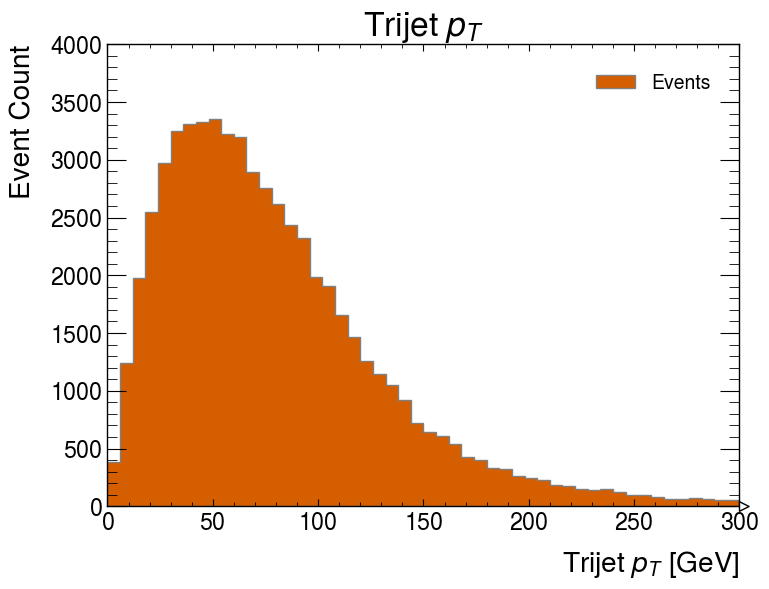

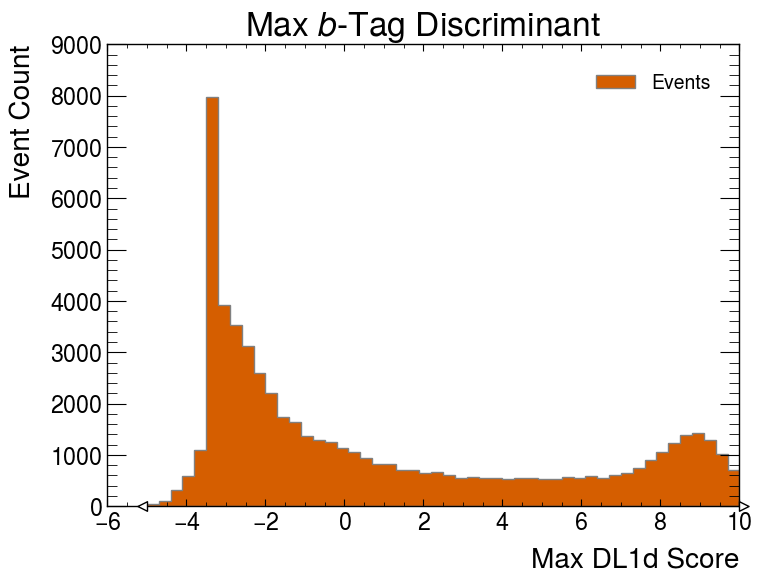

In [4]:
web_data = web_load_data_from_sx()
web_h_data = web_generate_histogram_data(web_data)
web_plot_hist(web_h_data)

## Current Running

And this is the broken stuff

In [5]:
def load_data_from_sx():
    # ServiceX/func_adl imports
    from func_adl_servicex_xaodr25 import FuncADLQueryPHYSLITE
    from servicex_analysis_utils import to_awk
    from servicex import deliver, ServiceXSpec, Sample, dataset

    # Tooling and type imports needed by the xAOD tool access helpers
    import ast
    from dataclasses import dataclass
    from typing import Callable, Iterable, List, Optional, TypeVar, Tuple
    from func_adl import ObjectStream
    from func_adl import func_adl_callable
    from func_adl_servicex_xaodr25.xAOD.jet_v1 import Jet_v1

    # === xAOD Tool Access helpers (copied and slightly augmented with missing imports) ===
    T = TypeVar("T")

    @dataclass
    class ToolInfo:
        name: str

    def make_a_tool(
        query: ObjectStream[T],
        tool_name: str,
        tool_type: str,
        include_files: Optional[List[str]],
        init_lines: List[str] = [],
    ) -> Tuple[ObjectStream[T], ToolInfo]:
        """
        Injects C++ code into the query to initialize a tool of the specified type.
        """
        query_base = query.MetaData(
            {
                "metadata_type": "inject_code",
                "name": tool_name,
                "header_includes": include_files,
                "private_members": [f"{tool_type} *{tool_name};"],
                "instance_initialization": [
                    f'{tool_name}(new {tool_type} ("{tool_name}"))'
                ],
                "initialize_lines": [l.format(tool_name=tool_name) for l in init_lines],
                "link_libraries": ["xAODBTaggingEfficiencyLib"],
            }
        )
        return query_base, ToolInfo(name=tool_name)

    def make_tool_accessor(
        t_info: ToolInfo,
        function_name: str,
        source_code: List[str],
        arguments: Iterable[Tuple[str, type]],
        return_type_cpp: str,
        return_type_python: str
    ):
        """
        Creates a Python-callable accessor for a C++ tool in the func_adl query.
        """
        def tool_callback(
            s: ObjectStream[T], a: ast.Call
        ) -> Tuple[ObjectStream[T], ast.Call]:
            new_s = s.MetaData(
                {
                    "metadata_type": "add_cpp_function",
                    "name": function_name,
                    "code": [
                        "double result;",
                        *[l.format(tool_name=t_info.name) for l in source_code],
                    ],
                    "result": "result",
                    "include_files": [],
                    "arguments": [a[0] for a in arguments],
                    "return_type": return_type_cpp,
                }
            )
            return new_s, a

        def tool_call(**arg_dict):
            ...
        tool_call.__name__ = function_name
        tool_call.__annotations__['return'] = eval(return_type_python)

        return func_adl_callable(tool_callback)(tool_call)

    # === Build the ServiceX query ===
    # Base query on PHYSLITE
    base_query = FuncADLQueryPHYSLITE()

    # Define the BTaggingSelectionTool (77% WP) for accessing the b-tagging discriminant
    base_query, btag_tool = make_a_tool(
        base_query,
        "btag_discriminator",
        "BTaggingSelectionTool",
        include_files=["xAODBTaggingEfficiency/BTaggingSelectionTool.h"],
        init_lines=[
            'ANA_CHECK(asg::setProperty({tool_name}, "OperatingPoint", "FixedCutBEff_77"));',
            "ANA_CHECK({tool_name}->initialize());",
        ],
    )

    # Accessor to get the b-tagging discriminant (GNN tagger weight), b-tag (False) vs c-tag (True)
    tag_weight = make_tool_accessor(
        btag_tool,
        function_name="tag_weight",
        source_code=["ANA_CHECK({tool_name}->getTaggerWeight(*jet, result, false));"],
        arguments=[("jet", Jet_v1)],
        return_type_cpp="double",
        return_type_python="float",
    )

    # Event-level filter: keep events with at least 3 reconstructed jets
    # Then, per event, return lists of jet kinematics (GeV) and the b-tagging discriminant
    query = (
        base_query
        .Where(lambda e: e.Jets().Count() >= 3)
        .Select(lambda e: e.Jets())
        .Select(
            lambda jets: {
                "jet_pt":  jets.Select(lambda j: j.pt() / 1000.0),
                "jet_eta": jets.Select(lambda j: j.eta()),
                "jet_phi": jets.Select(lambda j: j.phi()),
                "jet_m":   jets.Select(lambda j: j.m() / 1000.0),
                "jet_btag_weight": jets.Select(lambda j: tag_weight(j)),
            }
        )
    )

    # Dataset: mc23 ttbar all-had DAOD_PHYSLITE
    ds_name = (
        "mc23_13p6TeV:mc23_13p6TeV.601237.PhPy8EG_A14_ttbar_hdamp258p75_allhad.deriv."
        "DAOD_PHYSLITE.e8514_s4369_r16083_p6697"
    )

    # Execute the query against ServiceX (use only 1 file here)
    result_by_sample = to_awk(
        deliver(
            ServiceXSpec(
                Sample=[
                    Sample(
                        Name="ttbar_allhad_jets",
                        Dataset=dataset.Rucio(ds_name),
                        NFiles=1,
                        Query=query,
                    )
                ]
            )
        )
    )

    # Return the awkward array for this sample
    return result_by_sample["ttbar_allhad_jets"]

In [6]:
import awkward as ak
import numpy as np
from typing import Dict
import vector

# Enable Vector methods on Awkward record arrays
vector.register_awkward()


def generate_histogram_data(data: ak.Array) -> Dict[str, ak.Array]:
    # 1) Build jet 4-vectors
    jets_p4 = ak.zip(
        {
            "pt": data.jet_pt,
            "eta": data.jet_eta,
            "phi": data.jet_phi,
            "mass": data.jet_m,
        },
        with_name="Momentum4D",
    )

    # 2) All unique 3-jet combinations per event
    trijets = ak.combinations(jets_p4, 3, fields=["j1", "j2", "j3"], axis=1)

    # Corresponding b-tag combinations per event (aligned with trijets)
    btag_triples = ak.combinations(
        data.jet_btag_weight, 3, fields=["b1", "b2", "b3"], axis=1
    )

    # Summed 4-vector and invariant mass for each trijet candidate
    trijet_sum_p4 = trijets.j1 + trijets.j2 + trijets.j3
    m_trijet = trijet_sum_p4.mass

    # 3) Select trijet candidate per event closest to 172.5 GeV
    target_mass = 172.5
    mass_diff = abs(m_trijet - target_mass)
    best_idx = ak.argmin(mass_diff, axis=1, keepdims=True)

    # Pick the best candidate per event (None if no trijet exists)
    best_trijet_sum = ak.firsts(trijet_sum_p4[best_idx])

    # Compute requested per-event quantities
    trijet_pt = best_trijet_sum.pt

    # Max b-tag in the selected trijet
    # Compute pairwise maxima to avoid stacking jagged arrays
    b1 = btag_triples.b1
    b2 = btag_triples.b2
    b3 = btag_triples.b3
    m12 = ak.where(b1 > b2, b1, b2)
    btag_max_per_cand = ak.where(m12 > b3, m12, b3)
    trijet_btag_max = ak.firsts(btag_max_per_cand[best_idx])

    # 4) Package outputs as flat per-event awkward arrays
    out: Dict[str, ak.Array] = {}
    out["trijet_pt"] = trijet_pt
    out["trijet_btag_max"] = trijet_btag_max
    return out

In [7]:
import awkward as ak
from typing import Dict
import numpy as np
from hist import Hist
import matplotlib.pyplot as plt
import mplhep as hep

plt.style.use(hep.style.ATLAS)


def plot_hist(data: Dict[str, ak.Array]):
    # Extract input arrays (strict arrays of numbers as provided)
    trijet_pt = ak.to_numpy(data["trijet_pt"])
    trijet_btag_max = ak.to_numpy(data["trijet_btag_max"])

    # Histogram: Trijet pT
    h_pt = Hist.new.Reg(50, 0, 500, name="pt", label="Trijet $p_T$ [GeV]").Int64()
    h_pt.fill(pt=trijet_pt)

    fig_pt, ax_pt = plt.subplots()
    h_pt.plot(ax=ax_pt, histtype="fill", linewidth=1, edgecolor="gray", label="Events")
    ax_pt.set_xlabel("Trijet $p_T$ [GeV]")
    ax_pt.set_ylabel("Event Count")
    ax_pt.set_title("Selected Trijet $p_T$")
    ax_pt.legend()
    plt.show()
    plt.close(fig_pt)

    # Histogram: Max b-tag discriminant in selected trijet
    h_btag = Hist.new.Reg(
        50, -5, 10, name="disc", label="Max b-tag discriminant"
    ).Int64()
    h_btag.fill(disc=trijet_btag_max)

    fig_b, ax_b = plt.subplots()
    h_btag.plot(ax=ax_b, histtype="fill", linewidth=1, edgecolor="gray", label="Events")
    ax_b.set_xlabel("Max b-tag discriminant")
    ax_b.set_ylabel("Event Count")
    ax_b.set_title("Max b-Tag Discriminant (Selected Trijet)")
    ax_b.legend()
    plt.show()
    plt.close(fig_b)

Output()

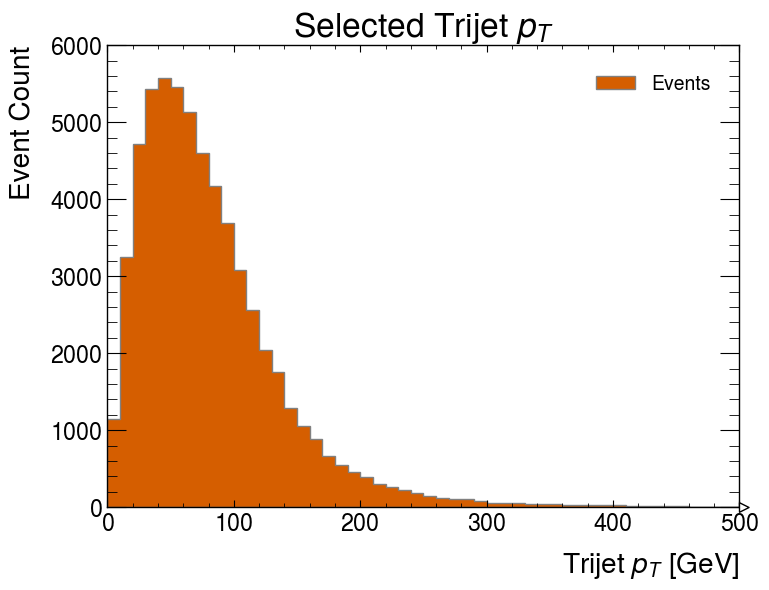

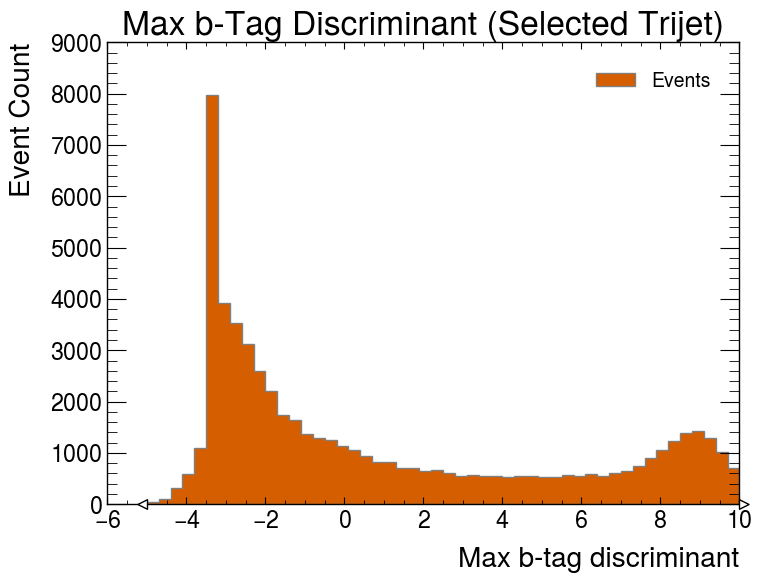

In [8]:
data = load_data_from_sx()
hist_data = generate_histogram_data(data)
plot_hist(hist_data)

## Figuring out what is different. We'll do mix and match.

First, try loading the data using the web stuff, but process everything the latest run.

Output()

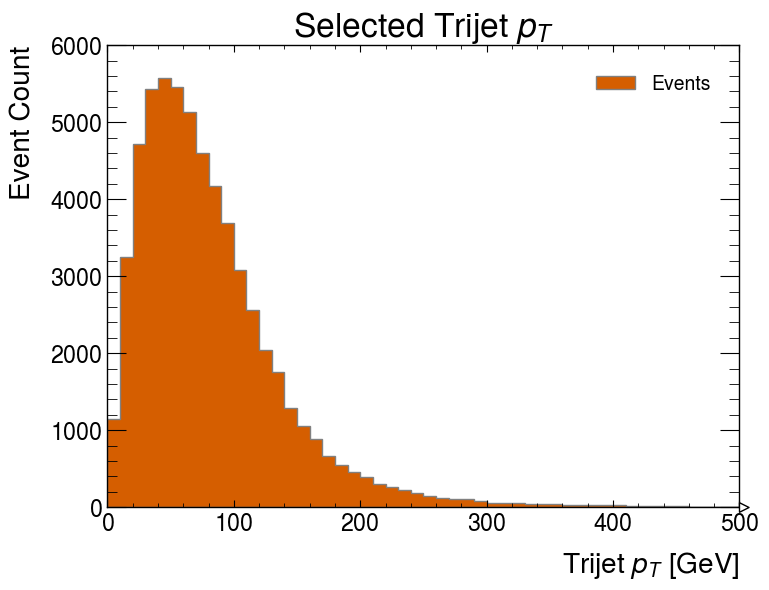

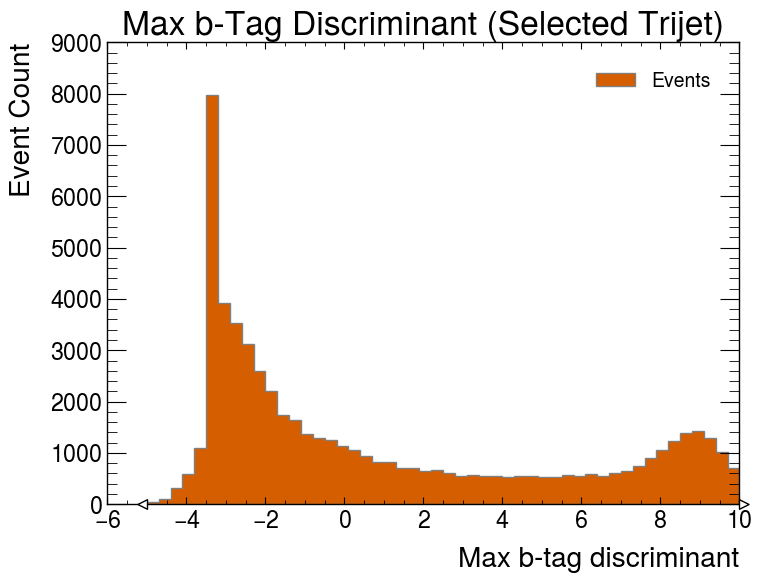

In [9]:
data = web_load_data_from_sx()
hist_data = generate_histogram_data(data)
plot_hist(hist_data)

Next, try the awkward processing from the web.

Output()

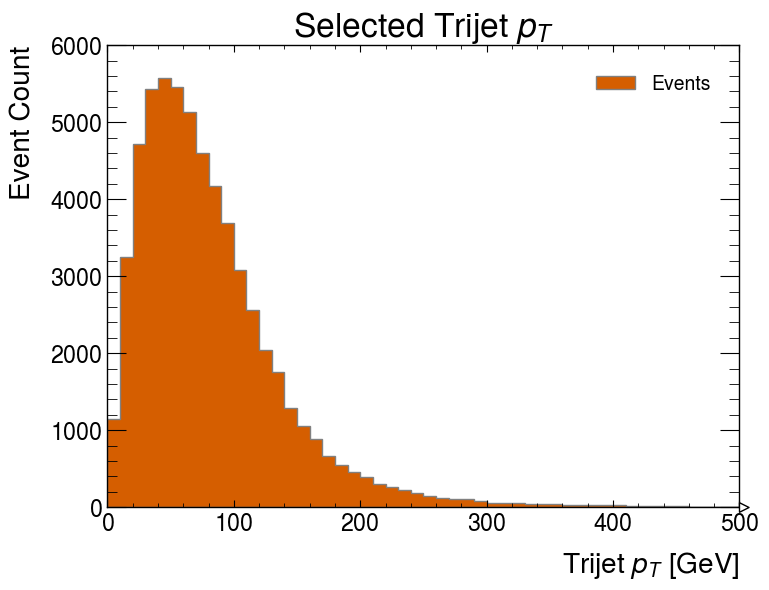

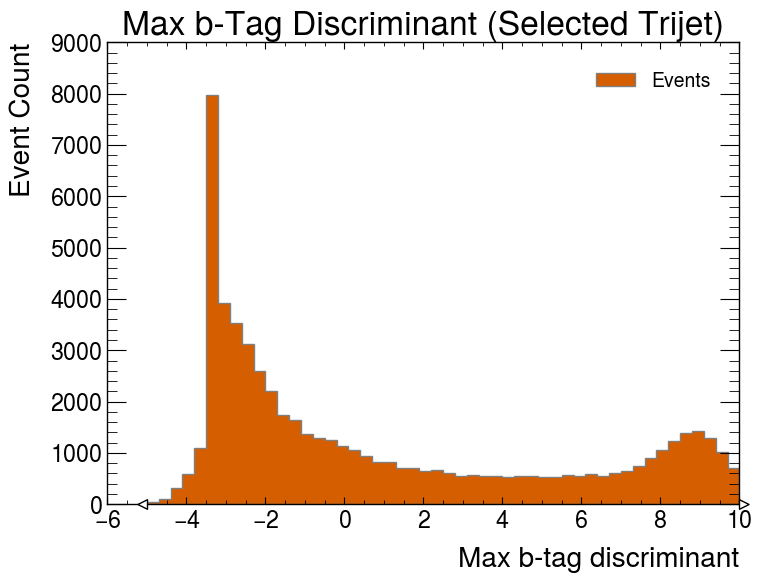

In [10]:
data = load_data_from_sx()
hist_data = web_generate_histogram_data(data)
plot_hist(hist_data)

It can't be the plotting!?

Output()

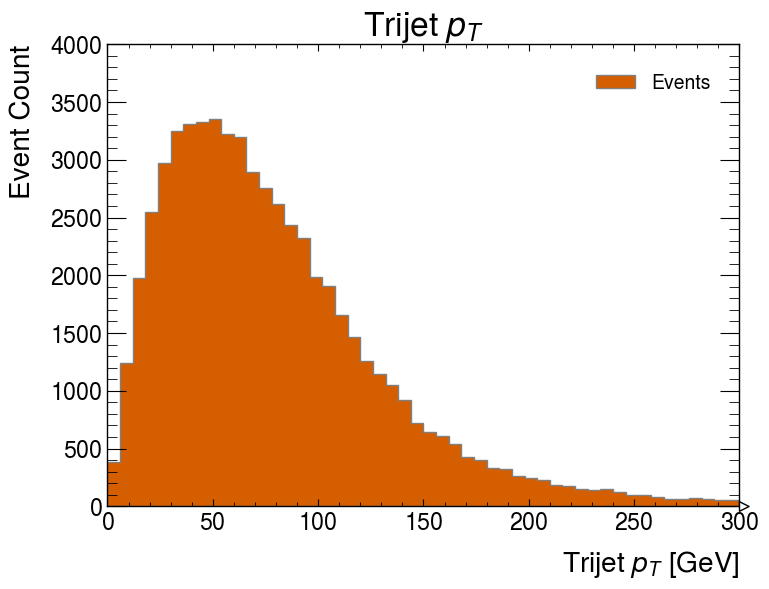

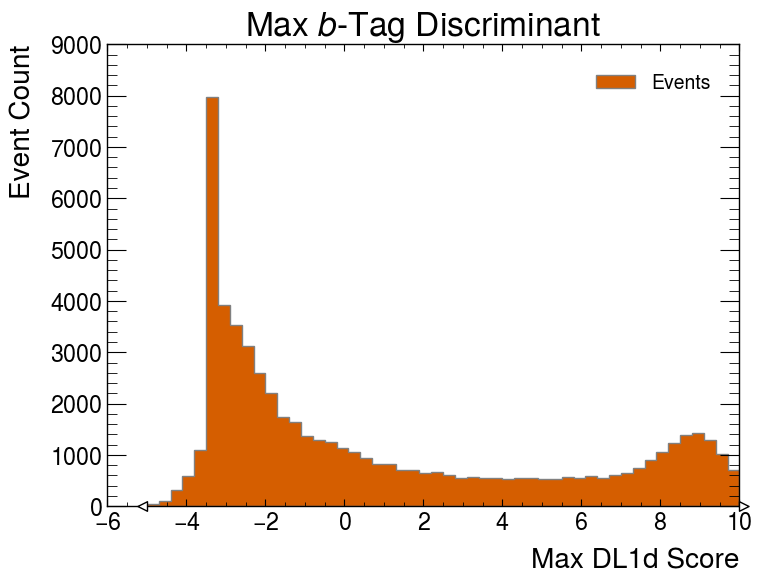

In [11]:
data = load_data_from_sx()
hist_data = generate_histogram_data(data)
web_plot_hist(hist_data)